In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import random
random.seed(42)

In [3]:
import numpy as np

In [4]:
import os
os.chdir("../")

In [5]:
import copy

In [6]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
## building vocab of chars & mapping to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [9]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
## Building the data set

block_size = 3 ## context length: How many chars to take to predict the next one?

X, Y = [], []

for w in words:
    context = [0] * block_size # -> 1st Iter [0, 0, 0]
    
    for ch in w + ".":

        ix = stoi[ch] ## Encoded values of character
        
        X.append(context) ## 1st Iter [0, 0, 0]
        Y.append(ix) ## 1st Iter [itos[ch]]

        context = context[1:] + [ix] ## Rolling Operation

X = torch.tensor(X)
Y = torch.tensor(Y)

In [11]:
def build_dataset(words: list[str]):
    
    block_size = 3 ## context length: How many chars to take to predict the next one?

    X, Y = [], []

    for w in words:
        context = [0] * block_size # -> 1st Iter [0, 0, 0]

        for ch in w + ".":

            ix = stoi[ch] ## Encoded values of character

            X.append(context) ## 1st Iter [0, 0, 0]
            Y.append(ix) ## 1st Iter [itos[ch]]

            context = context[1:] + [ix] ## Rolling Operation

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y
    

In [12]:
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

#### Understanding Generated X Shape & Y Shape

1. X shape is (N, Context Size). Where N is number of input samples generated while creating X, Y Pairs and Context Size is defined above

2. Y Shape is (N). For each Input Sample, it contains the next character Output

In [13]:
X.shape, X.dtype, 

(torch.Size([228146, 3]), torch.int64)

In [14]:
Y.shape, Y.dtype

(torch.Size([228146]), torch.int64)

## Projecting characters into 2 Dimensional Space (Embedding Look Up Table)

Number of Chars: 27

Dimensions: 2

In [15]:
C = torch.randn((27, 2))

### Accessing entries of Look-Up Matrix C

In [16]:
## For 5 encoded char "e"
## itos[5]
C[5]

tensor([-0.6791,  0.4441])

In [17]:
## For 0 encoded char "a"
## itos[5]
C[0]

tensor([0.8236, 0.2645])

In [18]:
## Is there a better way to index Look Up Matrix?
## Yes One Hot Encoding
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.6791,  0.4441])

In [19]:
## First Layer of Neural Language Model is essentially, look up into Embedding matrices for Provide Input

### Getting values for 5th Row & 0th Row simultaneously
C[[5, 0]]

tensor([[-0.6791,  0.4441],
        [ 0.8236,  0.2645]])

In [20]:
### Getting values for 5th Row , 6th Row & 7th Row ,7th Row, 7th Row simultaneously

C[torch.tensor([5, 6, 7, 7, 7])]

tensor([[-0.6791,  0.4441],
        [ 0.0692, -1.4254],
        [-1.2370, -0.0429],
        [-1.2370, -0.0429],
        [-1.2370, -0.0429]])

In [21]:
X.shape, X.dtype, 

(torch.Size([228146, 3]), torch.int64)

### How can I get Embedding Look Up entries for X Input `[N, Context Size]`

In [22]:
## Slicing X Tensor for Single word emma (1st name in data)
X_single_name = X[0:4, :]

In [23]:
X_single_name

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13]])

In [24]:
## In each row of X
## Number of encoded chars == context sizr
## For each encodeed chars -> (, 2) shape Look-Up Embedding Table output

## End Shape would look like
## (N, Context_Size, Embedding Dim)
C[X_single_name], C[X_single_name].shape

(tensor([[[ 0.8236,  0.2645],
          [ 0.8236,  0.2645],
          [ 0.8236,  0.2645]],
 
         [[ 0.8236,  0.2645],
          [ 0.8236,  0.2645],
          [-0.6791,  0.4441]],
 
         [[ 0.8236,  0.2645],
          [-0.6791,  0.4441],
          [ 0.1915, -0.4355]],
 
         [[-0.6791,  0.4441],
          [ 0.1915, -0.4355],
          [ 0.1915, -0.4355]]]),
 torch.Size([4, 3, 2]))

In [25]:
X[13, 2]

tensor(1)

In [26]:
C[X][13,2]

tensor([0.1296, 1.8787])

In [27]:
C[1]

tensor([0.1296, 1.8787])

In [28]:
## We can embedd directly by passing X into C and it should work!

emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [29]:
### Constructing Hidden Layer

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [30]:
### Embedding which is input to Hidden Layer has shape of [N, context, embedding dimension] -> (32, 3, 2)
### While Hidden layer neuron shape is (context * embedding dimension, hidden_dim) -> (6, 100)

### Last 2 dimensions of embedding layer needs to combined together so that shape matches for matmul

### One way to solve is to use torch cat function

torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [31]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([228146, 6])

In [32]:
### More generic way would be use torch unbind and then use torch cat
### Unbinding is done on dimension where context size is defined

torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[ 0.8236,  0.2645,  0.8236,  0.2645,  0.8236,  0.2645],
        [ 0.8236,  0.2645,  0.8236,  0.2645, -0.6791,  0.4441],
        [ 0.8236,  0.2645, -0.6791,  0.4441,  0.1915, -0.4355],
        ...,
        [-0.3496, -0.2976, -0.3496, -0.2976, -1.2193, -1.1166],
        [-0.3496, -0.2976, -1.2193, -1.1166, -0.3496, -0.2976],
        [-1.2193, -1.1166, -0.3496, -0.2976,  1.6430,  0.4001]])

In [33]:
Input_Embedding_Proj = copy.deepcopy(C[X])

In [34]:
Input_Embedding_Proj.shape

torch.Size([228146, 3, 2])

In [35]:
#### Easier way to do this

a = torch.arange(18)
a 

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [36]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [37]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [38]:
emb.shape

torch.Size([228146, 3, 2])

In [39]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [40]:
h

tensor([[-0.0670, -0.8029,  0.5071,  ...,  0.2035,  0.6939, -0.9772],
        [ 0.2808, -0.8977, -0.9271,  ..., -0.3786, -0.0721, -0.9868],
        [-0.9958,  0.4134,  0.6872,  ..., -0.9160,  0.6394,  0.7937],
        ...,
        [-0.9360,  0.9946, -0.9988,  ...,  0.2978, -0.7199,  0.7613],
        [-0.9880,  0.9978,  0.7945,  ...,  0.4717,  0.7396, -0.4796],
        [-0.6926,  0.9233,  0.9932,  ...,  0.9232,  0.9169, -0.8818]])

In [41]:
### Output Layer

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [42]:
logits = h @ W2 + b2

In [43]:
loss = F.cross_entropy(logits, Y)

In [44]:
loss

tensor(15.7854)

#### Training Loop 

In [45]:
X.shape, Y.shape ## DataSet

(torch.Size([228146, 3]), torch.Size([228146]))

In [46]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 2), generator=g, requires_grad=True)

W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)

W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [47]:
sum(p.nelement() for p in parameters)

3481

In [48]:
## Estimating Optimal Learning Rate

### Why we want to do that?
### so that we we get optimal learning rate, leading to reduction in loss in less amount of time & computation

### How to do that?

#### Compute loss for different learning rates & at different epochs
#### start with low learning rate, then gradually increase it
#### Select LR which gives lower loss



In [49]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [50]:
lri = []

lossi = []

for i in range(1000):

    # Adding MiniBatch Gradient Descent
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward Pass
    emb = C[X[ix]]

    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Y[ix])


    # print(loss.item())

    ## Backward pass 

    for p in parameters:
        p.grad = None

    loss.backward()

    ## Update

    ## Trying to find optimal learning rate
    lr = lrs[i]
    for p in parameters: 
        p.data += -lr * p.grad

    lri.append(lre[i].item())
    lossi.append(loss.item())

# print(loss.item())


In [ ]:
lri

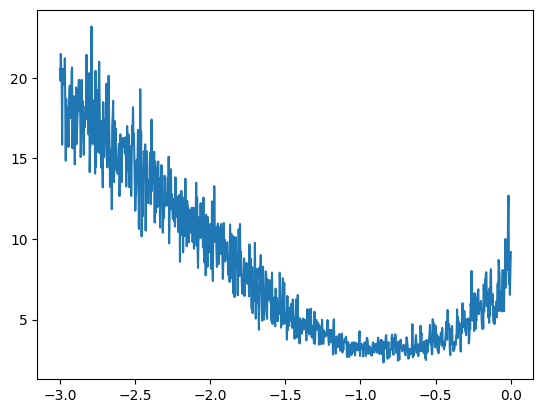

In [51]:
plt.plot(lri, lossi)

In [52]:
g = torch.Generator().manual_seed(217483647)

C = torch.randn((27, 2), generator=g, requires_grad=True)

W1 = torch.randn((6, 200), generator=g, requires_grad=True)
b1 = torch.randn(200, generator=g, requires_grad=True)

W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [53]:
sum(p.nelement() for p in parameters)

6881

In [54]:
lri = []
lossi = []
stepi = []

In [74]:
for i in range(100000):

    # Adding MiniBatch Gradient Descent
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward Pass
    emb = C[Xtr[ix]]

    h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, Ytr[ix])


    # print(loss.item())

    ## Backward pass 

    for p in parameters:
        p.grad = None

    loss.backward()

    ## Update

    ## Trying to find optimal learning rate
    lr = 0.01 / 2
    for p in parameters: 
        p.data += -lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss)


tensor(2.1700, grad_fn=<NllLossBackward0>)


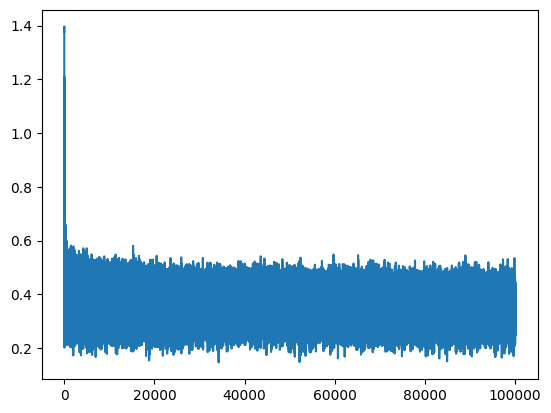

In [75]:
plt.plot(stepi, lossi)

### Train

In [76]:
emb = C[Xtr]

h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ytr)

loss

tensor(2.1916, grad_fn=<NllLossBackward0>)

### Validation

In [77]:
emb = C[Xdev]

h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ydev)

loss

tensor(2.2047, grad_fn=<NllLossBackward0>)

In [ ]:
## Training Split, Validation Split, Test Split 
# 80%, 10%, 10%

### Visualizing Character embedding matrix

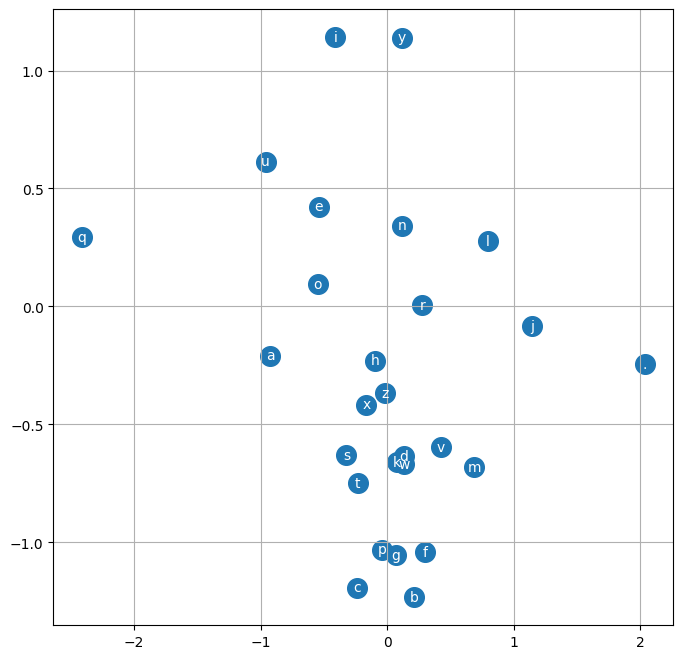

In [78]:
plt.figure(figsize=(8, 8))

plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')

In [ ]:
Xdev

### Inferencing

In [ ]:
emb = C[Xdev]

h = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1)

logits = h @ W2 + b2

loss = F.cross_entropy(logits, Ydev)

loss

In [80]:
W1.shape

torch.Size([6, 200])

In [81]:
for k in range(10):

    initial_context = [0 , 0 , 0]
    out = []

    while True:

        emb = C[initial_context] ## Embedding Look Up

        h = torch.tanh(emb.view(1, 6) @ W1 + b1) ## Hidden Layer Output

        logits_ = h @ W2 + b2

        prob_ = logits_.softmax(dim=-1)

        
        ix = torch.multinomial(prob_, num_samples=1, replacement=True, generator=g).item()

        initial_context.append(ix)

        initial_context = initial_context[1:]

        if ix == 0:
            break

        out.append(itos[ix])



    
    print("".join(out))

adlyn
dam
jayne
emmyt
him
vachedi
orceriel
colianna
datiari
tevi
